<a href="https://colab.research.google.com/github/jurandifr/Python/blob/main/hairParse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Referencias
# https://github.com/zllrunning/face-parsing.PyTorch/blob/master/model.py
# https://pypi.org/project/pytorchcv/

# Instalação da biblioteca
!pip install pytorchcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 23.1 MB/s eta 0:00:00


In [ ]:
# Bibliotecas de deepLearning
import torch
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.transforms as transforms

# Para puxar arquivo da internet
from requests import get

# Para manipular arquivos de imagem
import cv2
import numpy as np

# Para exibir o resultado
import matplotlib.pyplot as plt

# Informa se a GPU está ativada
print(f'Processamento em GPU : {torch.cuda.is_available()}')

# carrega o arquivo de imagem
def pega_imagem(caminho:str, filename:str='/content/imagem_web.jpg'):
  if caminho is None:
    return cv2.imread('/content/imagem_web.jpg')[:,:,::-1]
  elif 'http' in caminho:
    with open(f'{filename}','wb') as f:
      f.write(get(caminho).content)
    return cv2.imread(f'{filename}')[:,:,::-1]
  else:
    return cv2.imread(caminho)[:,:,::-1]

def criar_mascara(imagem):
  # Carregar o modelo BiSeNet pré-treinado
  model = ptcv_get_model('bisenet_resnet18_celebamaskhq', pretrained=True)

  # Transformar a imagem
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((640, 480)),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  img = transform(imagem.copy()).unsqueeze(0)

  with torch.no_grad():
      model.eval()
      output = model(img)[0]
      output = output.squeeze().cpu().numpy()
      output = np.argmax(output, axis=0)

  hair_class_index = 17  # Índice da classe do cabelo no CelebAMask-HQ
  hair_mask = (output == hair_class_index).astype(np.uint8)
  return cv2.resize(hair_mask, (imagem.shape[1], imagem.shape[0]))


# Cria a imagem sobreposta e colorida pela mascara
def colorir(imagem, mascara, cor=(255, 0, 0), opacidade = 0.15 ):
  imagem_colorida = np.zeros_like(imagem)
  imagem_colorida[mascara == 1] = cor
  imagem_final = imagem.copy()
  imagem_final[mascara == 1] = cv2.addWeighted(
      imagem[mascara == 1], 1 - opacidade,
      imagem_colorida[mascara == 1], opacidade, 0)
  return imagem_final


# plota a grade com as alterações de cor
def gradeColorida(url:str=None, opacidade= 0.15):
  imagem = pega_imagem(url)
  mascara = criar_mascara(imagem)

  fig = plt.figure(figsize=(12, 9))
  rows, columns=3,5
  fig.add_subplot(rows, columns, 1)
  plt.imshow(imagem)
  plt.axis('off')
  plt.title("Original")

  # dicionario de cores usado para compor grade
  cores = {
    'Preto': (0, 0, 0),
    'Castanho Escuro': (75, 54, 33),
    'Castanho Médio': (111, 78, 55),
    'Castanho Claro': (166, 123, 91),
    'Louro Escuro': (210, 180, 140),
    'Louro Médio': (240, 230, 140),
    'Louro Claro': (250, 250, 210),
    'Louro Platinado': (255, 248, 220),
    'Ruivo': (165, 42, 42),
    'Ruivo Claro': (255, 69, 0),
    'Ruivo Acobreado': (184, 115, 51),
    'Louro Morango':(255, 99, 71),
    'Azul':(0, 0, 200),
    'Violeta' : (200,0,200)
  }

  for i,(cor,rgb) in enumerate(cores.items()):
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(  colorir(imagem, mascara, cor = rgb, opacidade = opacidade ) )
    plt.axis('off')
    plt.title(cor)

Processamento em GPU : True


Uso

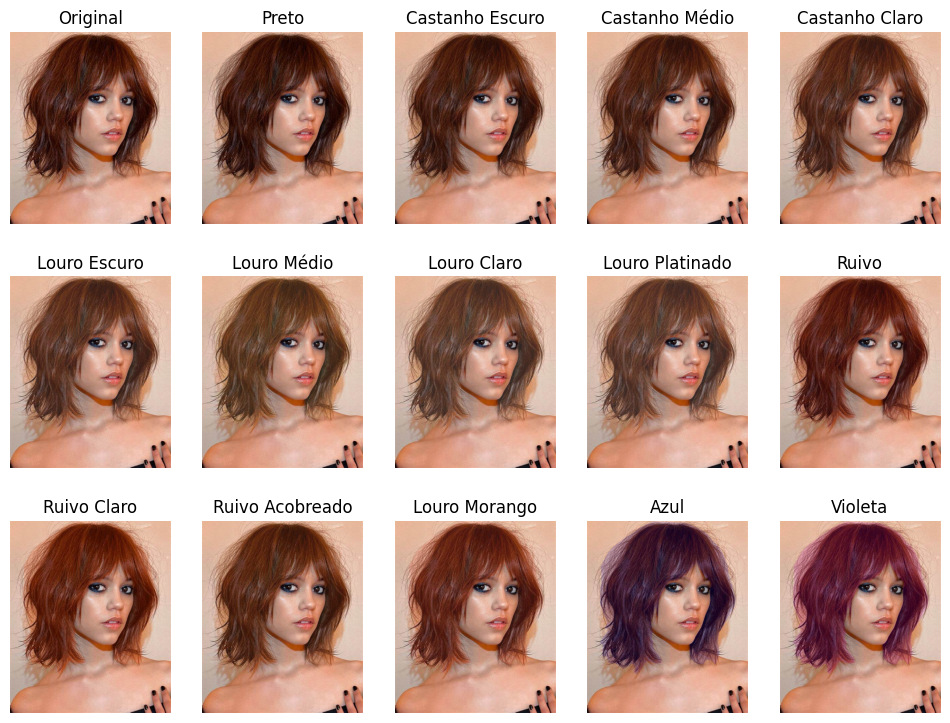

In [ ]:
gradeColorida('https://media.glamour.mx/photos/63a0809e28914bfa8e772d0a/master/w_1600%2Cc_limit/jenna_ortega_corte_bob_de_lobo.jpg', opacidade = 0.15)
# gradeColorida('/content/OIP.jpg', 0.15)